In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
from ConcentrationBehavior import ConcentrationBehavior
import pandas as pd
import numpy as np
from plot_utils import *
import matplotlib.style as style
style.use('seaborn-poster') 
style.use('seaborn-white')

In [6]:
n_pairs = [2, 4, 8, 12]
n_imgs = np.asarray([4, 9, 16, 25])

In [5]:
fns = ["aidapiccato-concentration-ios-20200127-142123.mwk2", "aidapiccato-concentration-ios-20200127-111036.mwk2"]
behave = ConcentrationBehavior(fns)

# High-level performance measures

## Block-level performance

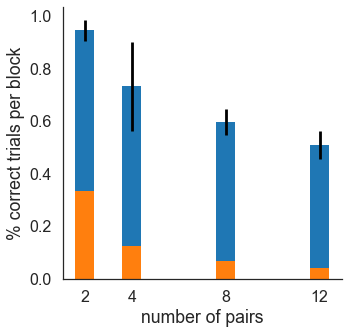

In [8]:
f, axs = plt.subplots(1, 1, figsize=(5, 5))
df = pd.concat([behave.scalar.n_pairs, behave.scalar.success, behave.scalar.block_index], axis=1)
mean = df.groupby(['n_pairs', 'block_index'])['success'].apply(np.mean).mean(level=0)
std = df.groupby(['n_pairs', 'block_index'])['success'].apply(np.mean).std(level=0)
chance = 1/(n_imgs - 1)
axs.bar(n_pairs, mean, yerr=std)
axs.bar(n_pairs, chance)
axs.set_xticks(n_pairs)
axs.set_xlabel('number of pairs')
axs.set_ylabel('% correct trials per block')
prettify(axs)

## Learning trajectory across grid sizes

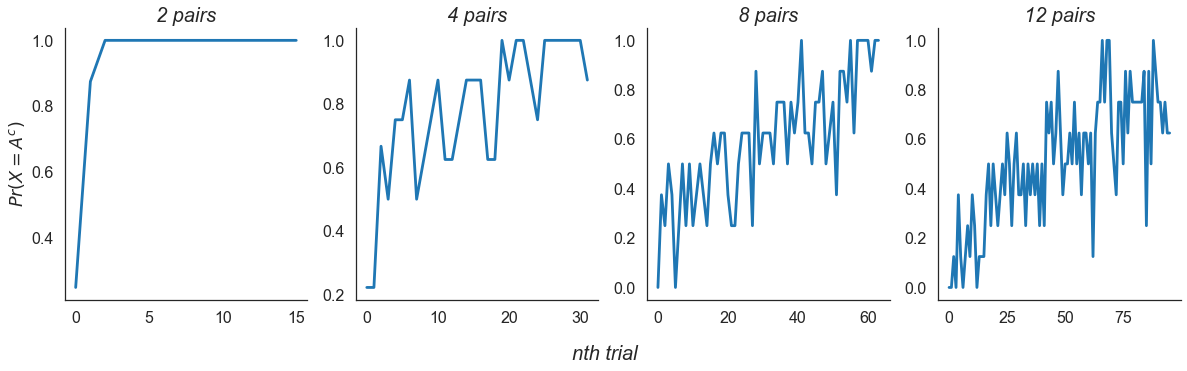

In [10]:
df = pd.concat([behave.scalar.success, behave.scalar.n_pairs, behave.scalar.trial_in_block_index], axis=1)
df = df.groupby(['n_pairs', 'trial_in_block_index'])['success'].apply(np.mean).unstack()
nrows, ncols = 1, 4
f, axs = plt.subplots(nrows, ncols, figsize=(20, 5))
max_n_trials = n_imgs.max() * 4
for i, k in enumerate(n_pairs):
    n_trials = k * 2 * 4
    axs[i].plot(np.arange(n_trials), df.iloc[i, :n_trials].values, label=k) 
for i, ax in enumerate(axs):
    ax.set_title('%d pairs' % (n_pairs[i]))
    prettify(ax)
axs[0].set_ylabel('$Pr(X = A^c)$')
plt.suptitle('nth trial', y = 0.0, fontsize = 20, style='italic')
plt.show()

# Temporal performance

## $\text{Pr}(X = A^{c})$ as a function of $A^c(t)$

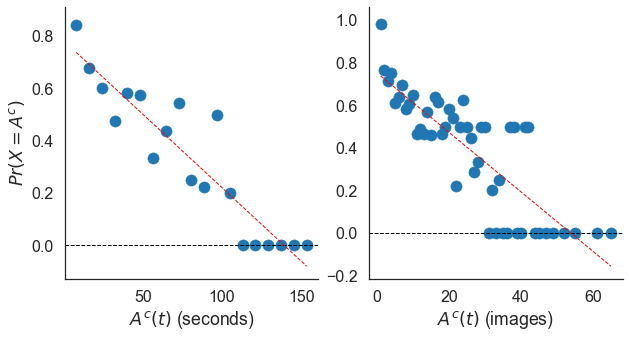

In [11]:
df = pd.concat([behave.temporal.t_c_cont_bin, behave.temporal.t_c_disc, behave.scalar.success], axis=1)
df = df[~df.t_c_cont_bin.isna()]
bins = ConcentrationBehavior.get_interval_array(df, 't_c_cont_bin') / 10**6
f, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax in axs:
    hline(ax, 0)
axs[0].scatter(bins, df.groupby('t_c_cont_bin')['success'].mean())
axs[0].set_ylabel('$Pr(X = A^c)$')
axs[0].set_xlabel('$A^c(t)$ (seconds)')
r_value, p_value, std_err = fit_line(axs[0], bins, df.groupby('t_c_cont_bin')['success'].mean().values)

axs[1].scatter(np.sort(df.t_c_disc.unique()), df.groupby('t_c_disc')['success'].mean())
axs[1].set_xlabel('$A^c(t)$ (images)')
r_value, p_value, std_err = fit_line(axs[1], np.sort(df.t_c_disc.unique()), df.groupby('t_c_disc')['success'].mean().values)
for ax in axs:
    prettify(ax)
plt.show()

# Spatial performance

## $\text{Pr}(X = A^c)$ as a function of spatial distance between $A$ and $A^c$

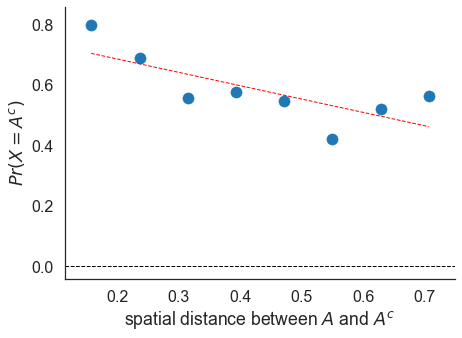

In [16]:
df = pd.concat([behave.spatial.dist_a_c_bin, behave.scalar.success], axis=1)
bins = ConcentrationBehavior.get_interval_array(df, 'dist_a_c_bin')
f, axs = plt.subplots(1, 1, figsize=(7, 5))
axs.scatter(bins, df.groupby('dist_a_c_bin')['success'].mean())
hline(axs, 0.0)
r_value, p_value, std_err = fit_line(axs, bins, df.groupby('dist_a_c_bin')['success'].mean())
axs.set_xlabel('spatial distance between $A$ and $A^c$')
axs.set_ylabel('$Pr(X = A^c)$')
prettify(axs)
plt.show()

## Spatial distance between $X$ and $A^c$ on incorrect trials over time

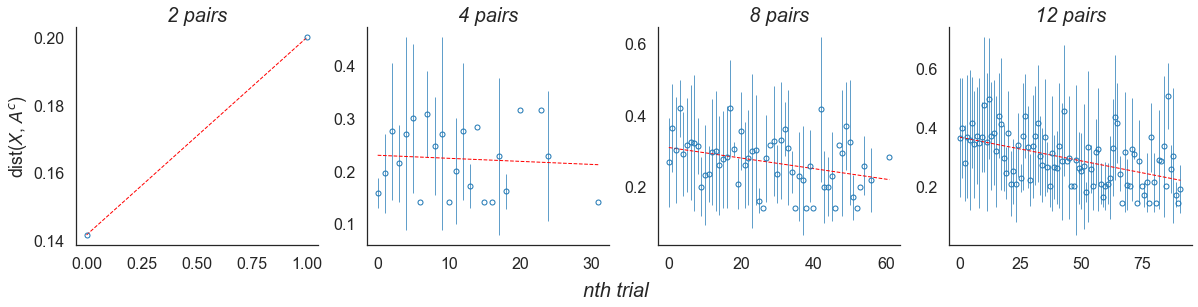

In [92]:
df = pd.concat([behave.spatial.dist_b_c, behave.scalar.n_pairs, behave.scalar.trial_in_block_index, behave.scalar.block_index, behave.scalar.success], axis = 1)
df = df[df.success == 0]
mean = df.groupby(['n_pairs', 'trial_in_block_index']).agg({'dist_b_c': lambda x: x.mean(skipna=False)}).unstack()
std = df.groupby(['n_pairs', 'trial_in_block_index']).agg({'dist_b_c': lambda x: x.std(skipna=False)}).unstack()
f, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, n in enumerate(n_pairs):
    n_trials = n * 2 * 4
    curr_mean = mean.iloc[i, :n_trials]
    curr_std = std.iloc[i, :n_trials]
    axs[i].errorbar(np.arange(len(curr_mean)), curr_mean[:n_trials], yerr=curr_std, fmt='o', elinewidth=0.7, fillstyle='none', markeredgewidth=1.0, markersize=5) 
    fit_line(axs[i], np.arange(len(curr_mean)), curr_mean)
for i, ax in enumerate(axs):
    ax.set_title('%d pairs' % (n_pairs[i]))
    prettify(ax)
axs[0].set_ylabel('dist($X$, $A^c$)')
plt.suptitle('nth trial', y = 0.0, fontsize = 20, style='italic')
plt.show()

## Freq. of selection for card b for each grid size

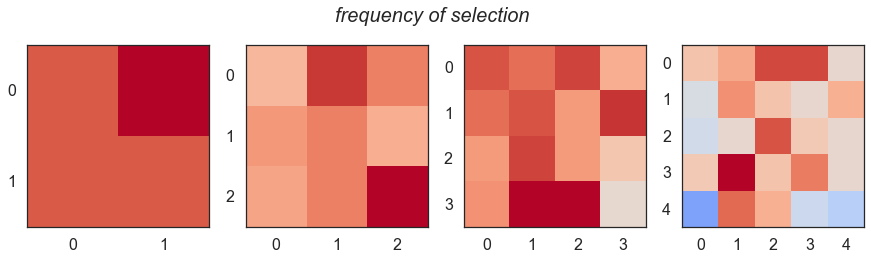

In [93]:
df = pd.concat([behave.scalar.card_b, behave.scalar.n_pairs], axis=1)
df = df[df.card_b != None]
n_touches = df.groupby(['n_pairs', 'card_b']).apply(len).unstack()
total_touches = df.groupby(['n_pairs']).apply(len)
f, axs = plt.subplots(1, 4, figsize=(15, 6))
n_pairs = [2, 4, 8, 12]
n_imgs = [4, 9, 16, 25]
grid_dims = [[2, 2], [3, 3], [4, 4], [5, 5]]
for i, n in enumerate(n_pairs):
    freqs = n_touches.iloc[i, :n_imgs[i]]/total_touches.iloc[i, ]
    img = axs[i].imshow(freqs.values.reshape(grid_dims[i])/np.amax(freqs.values), cmap='coolwarm', vmin=0, vmax=1)
    axs[i].set_xticks(np.arange(grid_dims[i][0]))
    axs[i].set_yticks(np.arange(grid_dims[i][0]))
plt.suptitle('frequency of selection', y=0.8, style='italic', fontsize=20)
plt.show()